In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import os
import tensorflow as tf
import pydot

from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont, ImageDraw, Image
import importlib

In [34]:
# Establecer el directorio del conjunto de datos
data_dir = 'Database'

In [35]:
# Definir parámetros para el modelo y las imágenes
batch_size = 32
img_height = 180
img_width = 180

In [36]:
# Cargar el conjunto de datos de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1557 files belonging to 2 classes.
Using 1246 files for training.


In [37]:
# Cargar el conjunto de datos de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1557 files belonging to 2 classes.
Using 311 files for validation.


In [38]:
# Obtener los nombres de las clases del conjunto de datos
class_names = train_ds.class_names
print(class_names)

['defected', 'no_defected']


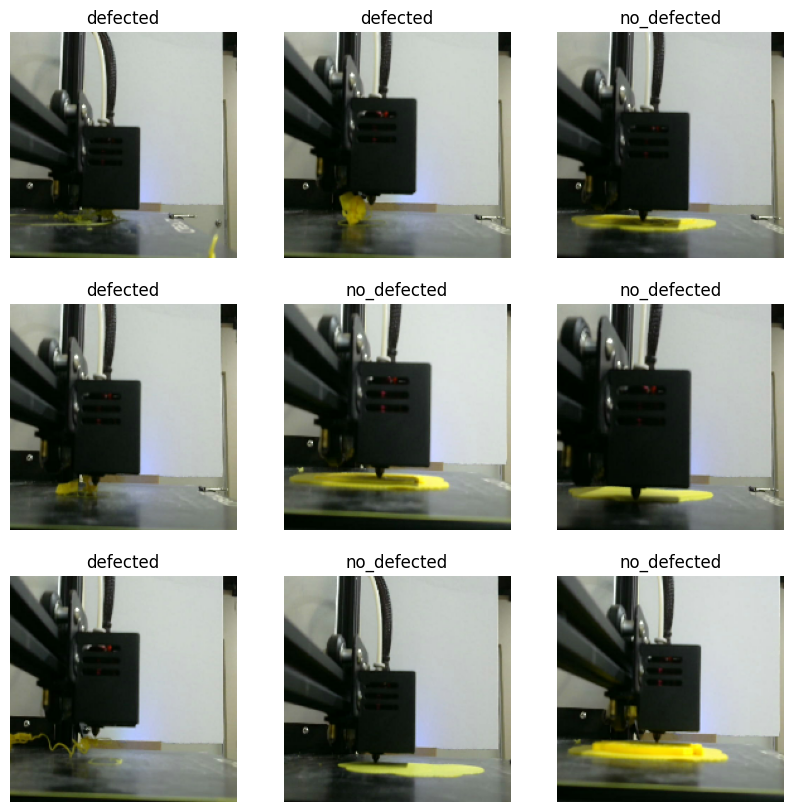

In [39]:
# Visualizar algunas imágenes del conjunto de datos de entrenamiento
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
# Imprimir la forma de lotes de imágenes y etiquetas
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [41]:
# Configurar la optimización del conjunto de datos para mejorar el rendimiento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
# Normalizar las imágenes para que los píxeles estén en el rango [0, 1]
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Modelo 1

In [43]:
num_classes = len(class_names)

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#guardamos el modelo en formato h5 para subirlo a 
model_1.save('model_1.h5')

In [45]:
#Entrenamiento del modelo
epochs=15
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.6596 - loss: 0.6891 - val_accuracy: 0.9839 - val_loss: 0.0801
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9835 - loss: 0.0772 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9994 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 3.6262e-04
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.9328e-04 - val_accuracy: 1.0000 - val_loss: 2.7504e-04
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.6985e-04 - val_accuracy: 1.0000 - val_loss: 2.2621e-04
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 1.6862e-04 - val_accuracy: 1.0000 - val_loss: 1.3040e-04
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - los

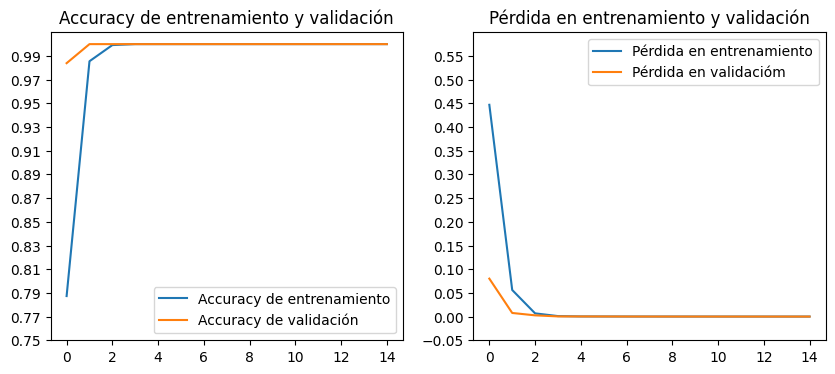

In [46]:
#Graficamos accuracy y pérdida del modelo según pasan las iteraciones
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy de entrenamiento')
plt.plot(epochs_range, val_acc, label='Accuracy de validación')
plt.legend(loc='lower right')
plt.title('Accuracy de entrenamiento y validación')
plt.ylim(0.75, 1.01)  # Ajusta los límites del eje Y
plt.yticks(np.arange(0.75, 1.01, 0.02))  # Ajusta el espaciado de las marcas en el eje Y


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida en entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en validacióm')
plt.legend(loc='upper right')
plt.title('Pérdida en entrenamiento y validación')
plt.ylim(-0.05, 0.6)   # Ajusta los límites del eje Y
plt.yticks(np.arange(-0.05, 0.6, 0.05))  # Ajusta el espaciado de las marcas en el eje Y
plt.show()

In [47]:
num_classes = len(class_names)

model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 

    # Bloque 1: Convolución + Convolución + MaxPooling
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloque 2: Convolución + Convolución + MaxPooling
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloque 3: Convolución + Convolución + MaxPooling 
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Capas densas con regularización Dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Ayuda a prevenir el sobreajuste
    layers.Dense(num_classes)
])

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,007,970 (122.10 MB)

 Trainable params: 32,007,970 (122.10 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
#guardamos el modelo en formato h5 para subirlo a 
model_2.save('model_2.h5')

In [49]:
#Entrenamiento del modelo
epochs=15
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6376 - loss: 0.7129 - val_accuracy: 0.9035 - val_loss: 0.1963
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9437 - loss: 0.1460 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9967 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 2.2539e-05
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 4.9620e-05
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 1.1944e-04 - val_accuracy: 1.0000 - val_loss: 1.7860e-05
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 5.1485e-04 - val_accuracy: 1.0000 - val_loss: 1.8996e-06
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 7.8699e-05 - val_accuracy: 1.0000 - val_loss: 4.9264e-05
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 1.0000 - loss: 4.1861e-0

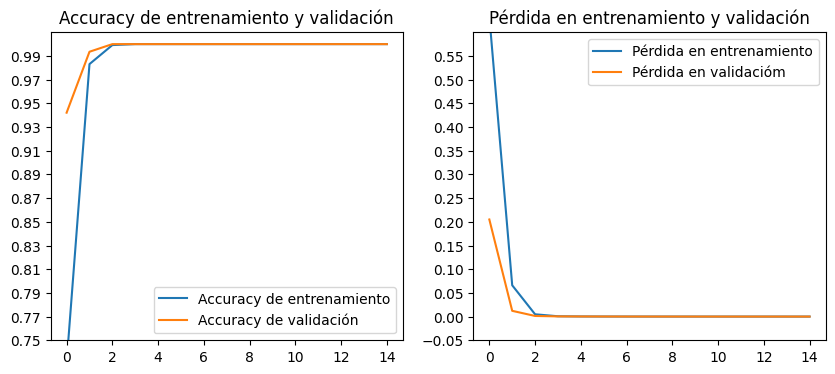

In [ ]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy de entrenamiento')
plt.plot(epochs_range, val_acc, label='Accuracy de validación')
plt.legend(loc='lower right')
plt.title('Accuracy de entrenamiento y validación')
plt.ylim(0.75, 1.01)  # Ajusta los límites del eje Y
plt.yticks(np.arange(0.75, 1.01, 0.02))  # Ajusta el espaciado de las marcas en el eje Y


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida en entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en validacióm')
plt.legend(loc='upper right')
plt.title('Pérdida en entrenamiento y validación')
plt.ylim(-0.05, 0.6)   # Ajusta los límites del eje Y
plt.yticks(np.arange(-0.05, 0.6, 0.05))  # Ajusta el espaciado de las marcas en el eje Y
plt.show()

### aumentar base de datos

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

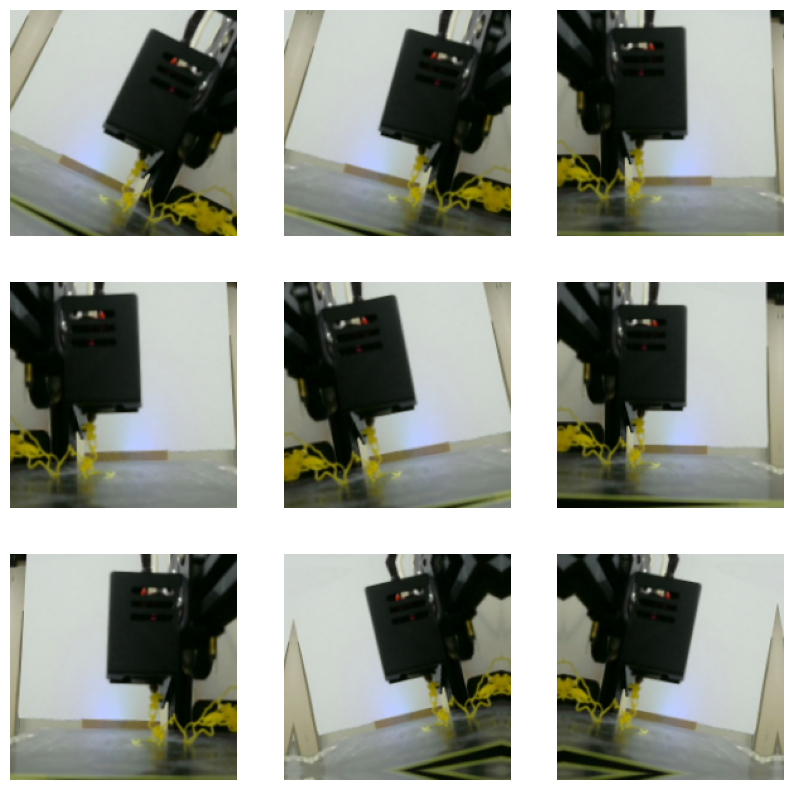

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Modelo 1 aprovechando el aumento de datos

In [ ]:
model_1_da = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model_1_da.build(input_shape=(None, img_height, img_width, 3)) 
model_1_da.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_1_da.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,294,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,299,874 (31.66 MB)

 Trainable params: 8,299,874 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
history = model_1_da.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.5360 - loss: 1.5853 - val_accuracy: 0.8296 - val_loss: 0.5180
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.7542 - loss: 0.5095 - val_accuracy: 0.7331 - val_loss: 0.4018
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8321 - loss: 0.3771 - val_accuracy: 0.8553 - val_loss: 0.3298
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8206 - loss: 0.3575 - val_accuracy: 0.8585 - val_loss: 0.2997
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.8297 - loss: 0.3316 - val_accuracy: 0.8553 - val_loss: 0.2944
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8517 - loss: 0.3067 - val_accuracy: 0.8585 - val_loss: 0.2715
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8552 - loss: 0.2961 - val_accuracy: 0.9068 - val_loss: 0.2071
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.8764 - loss: 0.2723 - val_accuracy: 0.

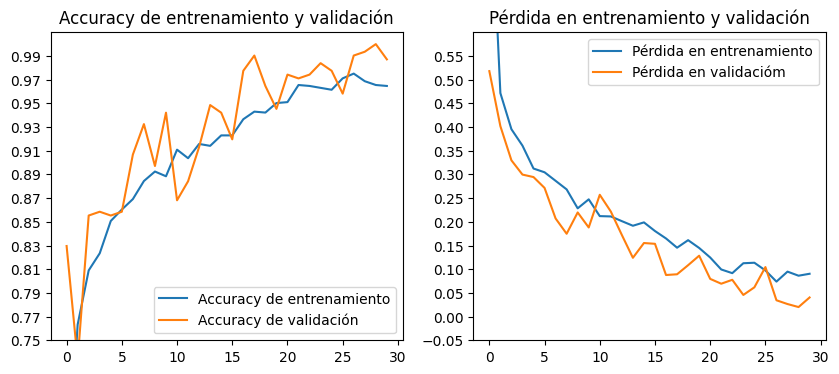

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy de entrenamiento')
plt.plot(epochs_range, val_acc, label='Accuracy de validación')
plt.legend(loc='lower right')
plt.title('Accuracy de entrenamiento y validación')
plt.ylim(0.75, 1.01)  # Ajusta los límites del eje Y
plt.yticks(np.arange(0.75, 1.01, 0.02))  # Ajusta el espaciado de las marcas en el eje Y


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida en entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en validacióm')
plt.legend(loc='upper right')
plt.title('Pérdida en entrenamiento y validación')
plt.ylim(-0.05, 0.6)   # Ajusta los límites del eje Y
plt.yticks(np.arange(-0.05, 0.6, 0.05))  # Ajusta el espaciado de las marcas en el eje Y
plt.show()